In [1]:
# load libs
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
#from torch.utils.tensorboard import SummaryWriter

In [2]:
# definition of a simple fc model [11, 32, 64, 1]
class MOGANet(nn.Module):
    def __init__(self):
        super(MOGANet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [3]:
random.seed(2019) 
torch.manual_seed(2019)
torch.cuda.manual_seed_all(2019)

model = MOGANet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

In [4]:
# load files
moga = pickle.load(open("moga.1124.pkl", "rb"))
x_train, x_test = moga["x_train"], moga["x_test"]
y_train, y_test = moga["y_train"], moga["y_test"]
x_mean, x_std = moga["x_mean"], moga["x_std"]

In [5]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

In [6]:
# set tensorboard directory
#writer = SummaryWriter('/home/ylu/moga/runs/1124')

In [7]:
for t in range(50000):
    model.train()
    Yp = model(x_train)
    loss = criterion(Yp, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    Yp_test = model(x_test)
    test_loss = criterion(Yp_test, y_test)
    
    #writer.add_scalars('Loss', {'train':loss.item(),'test':test_loss.item()}, t)

    scheduler.step(test_loss.item())

In [8]:
# save trained model
torch.save(model.state_dict(), 'moga-1124.pth')

In [9]:
model.eval()
Yp = model(x_test)
print("test MSE from criterion")
MSE = criterion(Yp, y_test).item()
print(MSE)

Yp = Yp[:,0].detach().numpy()
y_test = y_test[:,0].detach().numpy()

delta_y = Yp - y_test
RMSE = np.sqrt(MSE)
print("test RMSE of original data")
print(RMSE)

test MSE from criterion
1740.14501953125
test RMSE of original data
41.71504548159153


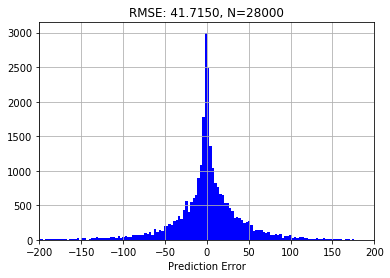

In [10]:
# plot RMSE
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(delta_y, num_bins, facecolor='blue')
plt.xlabel('Prediction Error')
plt.xlim(-200,200)
plt.grid(True)
plt.title('RMSE: %.4f, N=%d' % (RMSE,len(x_test)))
plt.show()

In [11]:
# check mean ans std
print(np.std(y_test))
print(np.mean(y_test))
print(max(y_test), min(y_test))

254.60405
-233.75337
0.0 -1171.5212


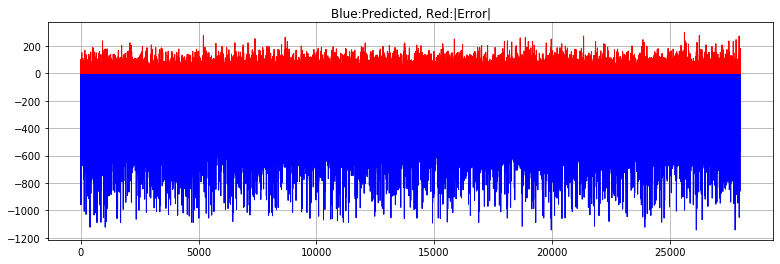

In [12]:
# Viz Yp and |Error|
l = np.array([x for x in range(len(y_test))])
plt.figure(figsize=(13,4))
plt.title("Blue:Predicted, Red:|Error|")
plt.plot(l, Yp, 'b-', linewidth=1)
plt.plot(l, abs(delta_y), 'r-', linewidth=1)
plt.grid(True)
plt.show()

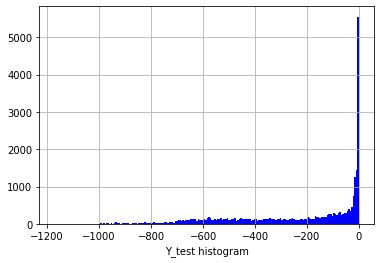

In [13]:
# Viz y_test hist
plt.figure(figsize=(6,4))
num_bins = 200
plt.hist(y_test, num_bins, facecolor='blue')
plt.xlabel('Y_test histogram')
plt.grid(True)
plt.show()